In [53]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from scipy.integrate import quad

# S(Q, $\omega$) generation

### Quasielastic width

In [54]:
D0 = 2.2e-5 #cm^2 s^-1
D0 = D0 * 1e4 # A^2 ps^-1
tau = 0.5 #ps
hbar = 6-582119514e-13 #meV s

W = lambda Q: hbar*D0*Q**2/(1+tau*D0*Q**2)

Text(0, 0.5, 'W (meV)')

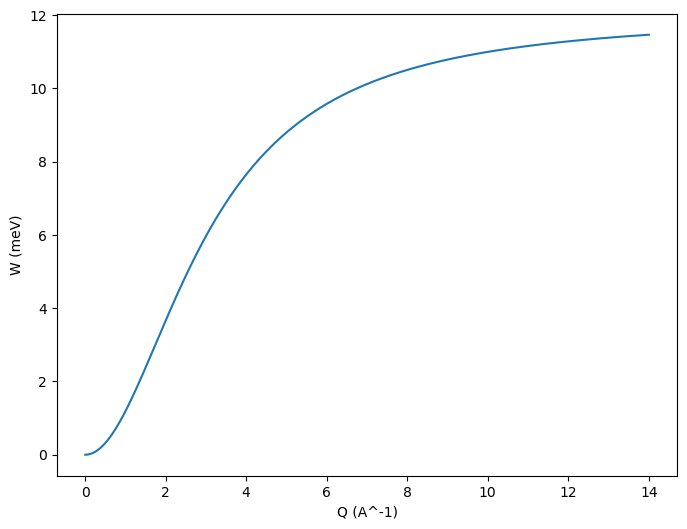

In [55]:
plt.figure(figsize=(8,6))
Q = np.linspace(0, 14, 1000)
plt.plot(Q, W(Q))
plt.xlabel('Q (A^-1)')
plt.ylabel('W (meV)')

In [56]:
S_el = lambda Q, omega: W(Q)/(np.pi*(omega**2 + W(Q)**2))

### Debye-Waller factor

In [57]:
DWD = 5
DWD = DWD/(4*np.pi)**2
print(1/DWD)

WD = lambda Q: DWD*Q**2
p0 = lambda Q: np.exp(-2*WD(Q)) 
p1 = lambda Q: 1-p0(Q)

31.582734083485946


Text(0, 0.5, 'p0')

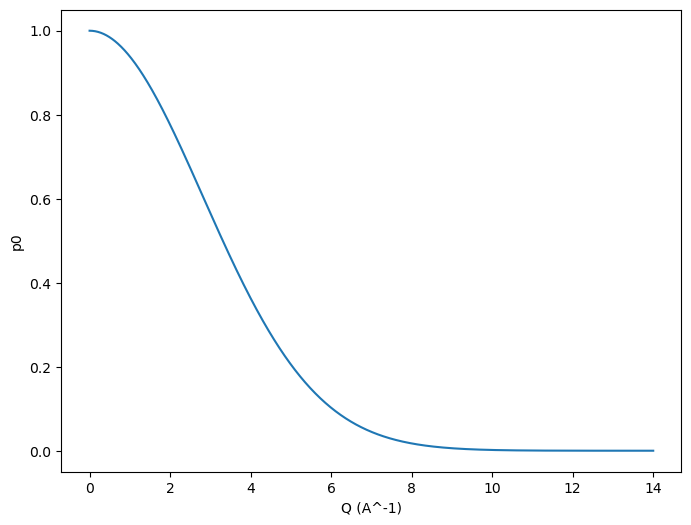

In [58]:
plt.figure(figsize=(8,6))
plt.plot(Q, p0(Q))
plt.xlabel('Q (A^-1)')
plt.ylabel('p0')

### S(Q)

In [59]:
dfSQ = pd.read_csv('./data_Sq/Sqw_generation/D2O_SQ.csv')
SQ = lambda x: np.interp(x, dfSQ['Q'], dfSQ['S'])

Text(0, 0.5, 'S(Q)')

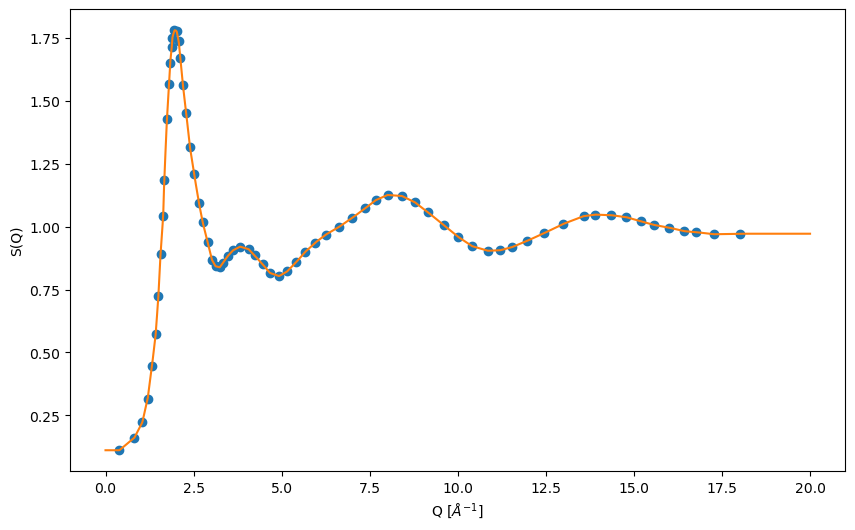

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(dfSQ.Q, dfSQ.S, label='S(Q)', color='C0')

X = np.linspace(0, 20, 1000)
Y = SQ(X)
plt.plot(X, Y, label='interpolated S(Q)', color='C1')

plt.xlabel(r'Q [$\AA^{-1}$]')
plt.ylabel('S(Q)')

### Inelastic function

In [61]:
omegaG = 25 #meV
WG = 25 #meV
beta = lambda T: 11.6045/T #meV^-1

b = 4*np.log(2)/WG #meV^-2

# BETAM = BETA/2
# BPG = b
# COSTP=SQRT(PG/BPG)*EXP(BETAM*E0G+3.*BETA**2/(16.*BPG))
# COSTM=SQRT(PG/BPG)*EXP(-BETAM*E0G+3.*BETA**2/(16.*BPG))
# COST=1./(COSTP+COSTM)
# COST è il parametro C_G

CG = lambda T: 1/(np.sqrt(np.pi/b)*np.exp(beta(T)*omegaG + 3*beta(T)**2/(16*b)) + np.sqrt(np.pi/b)*np.exp(-beta(T)*omegaG + 3*beta(T)**2/(16*b)))

S_inel = lambda Q, omega, T: CG(T)*np.exp(beta(T)*omega/2)*(np.exp(-b*(omega-omegaG)**2) + np.exp(-b*(omega+omegaG)**2))

In [62]:
S = lambda Q, omega, T: p0(Q)*S_el(Q, omega) + p1(Q)*S_inel(Q, omega, T)

## The model

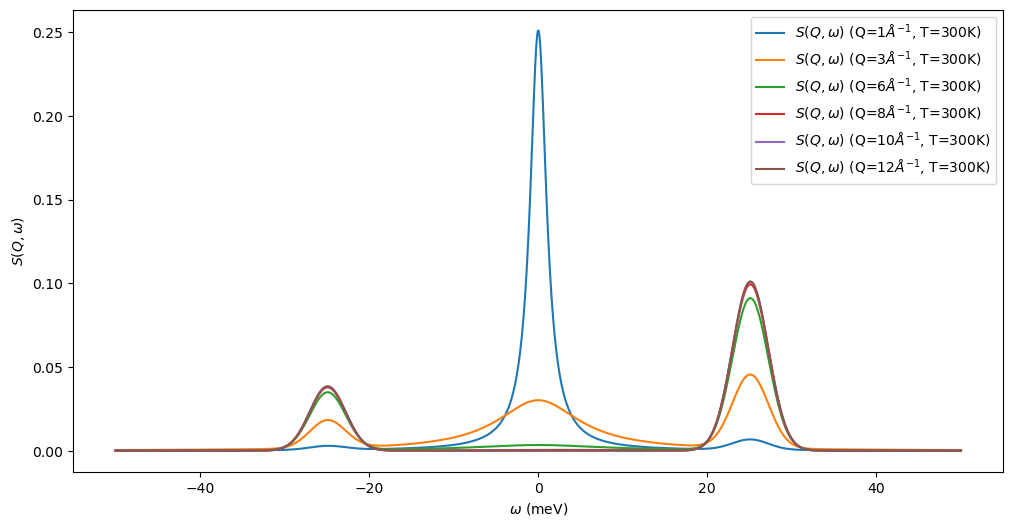

In [63]:
#########
T = 300
#########

X = np.linspace(-50, 50, 1000)
Y = S(Q, X, T)
plt.figure(figsize=(12,6))

for Q in [1, 3, 6, 8, 10, 12]:
    Y = S(Q, X, T)
    plt.plot(X, Y, label=r"$S(Q, \omega)$ (Q="+str(Q)+r"$\AA^{-1}$, T=300K)")

plt.xlabel(r'$\omega$ (meV)')
plt.ylabel(r'$S(Q, \omega)$')
plt.legend()


In [64]:
def S_model(Q, omega, T):
    omega_min = -400
    omega_max = 400

    S_tonorm = lambda omega: S(Q, omega, T)
    norm = quad(S_tonorm, omega_min, omega_max)[0]
    return S_tonorm(omega) / norm * (SQ(Q))

## Salvataggio della Mesh su S(Q, $\omega$)

In [72]:
# FILE GENERATION
Qmin, Qmax, dQ = .1, 14, .05
omega_min, omega_max, domega = -100, 100, .05

Q_vec = np.arange(Qmin, Qmax, dQ)
omega_vec = np.arange(omega_min, omega_max, domega)

T_d6 = [300]


for T in T_d6:
    S_mesh = np.array([S_model(Qmin, omega_vec, T)])
    for q in Q_vec[1:]:
        S_mesh = np.vstack((S_mesh, S_model(q, omega_vec, T )))

    np.save('./data_Sq/Sqw_D2O/Sqw_D2O_'+str(T)+'K', S_mesh)
np.save('./data_Sq/Sqw_D2O/Q_vec', Q_vec)
np.save('./data_Sq/Sqw_D2O/omega_vec', omega_vec)

Text(0, 0.5, '$Q$ ($\\AA^{-1}$)')

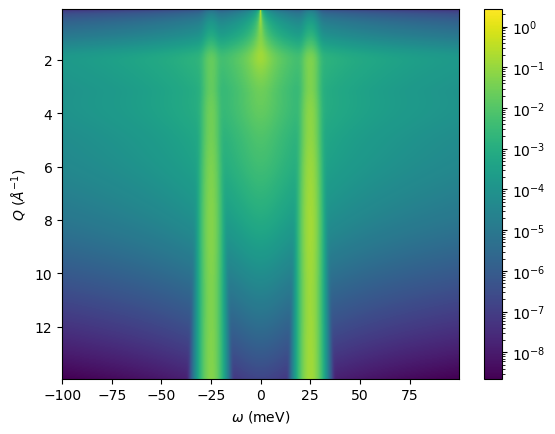

In [73]:
# LOAD EXAMPLE
S_mesh = np.load('./data_Sq/Sqw_D2O/Sqw_D2O_300K.npy')
Q_vec = np.load('./data_Sq/Sqw_D2O/Q_vec.npy')
omega_vec = np.load('./data_Sq/Sqw_D2O/omega_vec.npy')

plt.imshow(S_mesh, aspect='auto', extent = [omega_vec[0], omega_vec[-1], Q_vec[-1], Q_vec[0]], norm='log')
plt.colorbar()
plt.xlabel(r'$\omega$ (meV)')
plt.ylabel(r'$Q$ ($\AA^{-1}$)')